In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#import plotly.express as px
from scipy.interpolate import griddata
import seaborn as sns

import sys
sys.path.append('../../../AsymptoticSolver/')
sys.path.append('..')

from Utilities.coord_func import cart2pol
from Utilities.add_var import add_u_polar, get_bg_wind
from AsymptoticSolver import polar_dft, polar_idft, pick_fourier_comp

%matplotlib notebook

### 1. Get data

Initial data is taken from NARVAL simulation for the 17.08.2016 1200 UTC (initialized at 0000 UTC).
Center is calculated with method of centroid pressure.

__Constants:__  
lev_start: Level from where the calculation should start  
km: Radius around the cyclone center  
r_earth: Radius of earth  
r_rad: Radius around the cyclone center in radians

In [4]:
lev_start= 45             
km       = 250                           
r_earth  = 6371                     
r_rad    = km / r_earth

In [5]:
# Data for centerline
center_file       = "../Data/center_fiona.npy" 
center = np.load(center_file)
x_center = center[:,0]
y_center = center[:,1]


# Initial data
ds_orig = xr.open_dataset('../../../../init_data/dei4_NARVALII_2016081700_fg_DOM01_ML_0012.nc')

# Number of levels in file (highest index is lowest level -> p-system)
nlev = len(ds_orig.height.values)
height = ds_orig.z_ifc.values

In [8]:
# Get radial and tangential wind
ds_orig = add_u_polar(ds_orig, ds_orig.u[0], ds_orig.v[0], center)

Calculate u_r and u_phi for following levels: 8229.29 to 0.0


### 2. Polar coordinate transformation

Select a variable of interest because a memory error occurse when trying to manipulate the whole data set. Create a new polar coord. grid to interpolate the lon-lat data onto.

In [9]:
var_da = ds_orig.u_r[0]
#u_phi_da = ds_orig.u_phi[0]

# Extract region containing cyclone
lonlat_box = {'lon_up':-0.57,'lon_down':-0.68, 'lat_up': 0.17, 'lat_down': 0.30}

 # Select region of interest
var_da = var_da.where(var_da['clon'] < lonlat_box['lon_up'], drop=True)
var_da = var_da.where(var_da['clon'] > lonlat_box['lon_down'], drop=True)
var_da = var_da.where(var_da['clat'] > lonlat_box['lat_up'], drop=True)
var_da = var_da.where(var_da['clat'] < lonlat_box['lat_down'], drop=True)


In [10]:
cellID = var_da.ncells.values

lon = var_da.clon.values
lat = var_da.clat.values

# Create new grid
r_grid = np.linspace(0,r_rad,1000).transpose()
phi_grid = np.linspace(-np.pi,np.pi,1000,endpoint=False)
r_grid_da = xr.DataArray(r_grid, coords=[('r', r_grid)])
phi_grid_da = xr.DataArray(phi_grid, coords=[('phi', phi_grid)])

In [11]:
# Set level number
i = 50 

center_index = i- (nlev - len(center))-1
lev_index = i-1
lev_height = height[lev_index,0]

# Calculate r and phi for single level
r,phi = cart2pol(lon,lat,center[center_index,])

x_grid = x_center[center_index] + r_grid_da*np.cos(phi_grid_da)
y_grid = y_center[center_index] + r_grid_da*np.sin(phi_grid_da)

# Create new lon and lat positions using polar coordinates 
# (necessary to have all points for interpolation method):
x_polar = [x_center[center_index] + r_grid[j]*np.cos(phi_grid) \
            for j in range(len(r_grid))]
x_polar = np.asarray(x_polar).reshape((1,len(r_grid)*len(r_grid)))
y_polar = [y_center[center_index] + r_grid[j]*np.sin(phi_grid) \
            for j in range(len(r_grid))]
y_polar = np.asarray(y_polar).reshape((1,len(r_grid)*len(r_grid)))


In [12]:
values = var_da.values[lev_index]

lonlat_points = np.asarray([var_da.clon.values[:], var_da.clat.values[:]]).transpose()
polar_points = np.asarray([x_polar, y_polar]).reshape((2,len(x_polar[0]))).transpose()

# remap variables for circles with constant radius around center
var_remap = griddata(lonlat_points, values, polar_points, method='cubic')
var_remap = var_remap.reshape((len(r_grid),len(phi_grid)))

# Add polar coordinates as dimensions
var_polar_da = xr.DataArray(var_remap, coords={ 'r':('r',r_grid), \
                    'phi':('phi', phi_grid), 'x': x_grid , 'y': y_grid }, \
                    dims={'r': r_grid, 'phi':phi_grid })
var_polar_da = var_polar_da.fillna(0.)

In [13]:
# All modes
fvar = polar_dft(var_polar_da, polar_dim='phi')
fvar_i = polar_idft(fvar, polar_dim='phi')

# Select specific modes

# -4
fvar_neg4 = fvar.copy()
fvar_neg4[0:-4] = 0.
fvar_neg4[-3:] = 0.
fvar_neg4_i = polar_idft(fvar_neg4)

# -3
fvar_neg3 = fvar.copy()
fvar_neg3[0:-3] = 0.
fvar_neg3[-2:] = 0.
fvar_neg3_i = polar_idft(fvar_neg3)

# -2
fvar_neg2 = fvar.copy()
fvar_neg2[0:-2] = 0.
fvar_neg2[-1] = 0.
fvar_neg2_i = polar_idft(fvar_neg2)

# -1
fvar_neg1 = fvar.copy()
fvar_neg1[0:-1] = 0.
fvar_neg1_i = polar_idft(fvar_neg1)

# 0
fvar0 = fvar.copy()
fvar0[1:] = 0.
fvar0_i =polar_idft(fvar0)

# 1
fvar1 = fvar.copy()
fvar1[0] = 0.
fvar1[2:] = 0.
fvar1_i = polar_idft(fvar1)

#2
fvar2 = fvar.copy()
fvar2[0:2] = 0.
fvar2[3:] = 0.
fvar2_i =polar_idft(fvar2)

#3
fvar3 = fvar.copy()
fvar3[0:3] = 0.
fvar3[4:] = 0.
fvar3_i = polar_idft(fvar3)

#4
fvar4 = fvar.copy()
fvar4[0:4] = 0.
fvar4[5:] = 0.
fvar4_i = polar_idft(fvar4)


Text(0, 0.5, 'm s^-1')

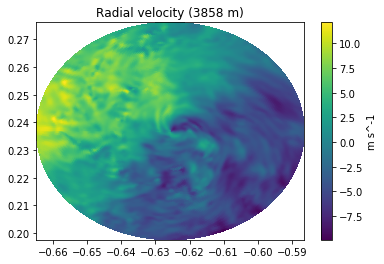

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.pcolor(fvar_i.x, fvar_i.y, xr.ufuncs.real(fvar_i))
ax.title.set_text('Radial velocity (%s m)' %  np.int(lev_height))
cbar = plt.colorbar(cs, ax=ax)
cbar.ax.set_ylabel('m s^-1')

Plot selected fourier modes next to each other.

<IPython.core.display.Javascript object>


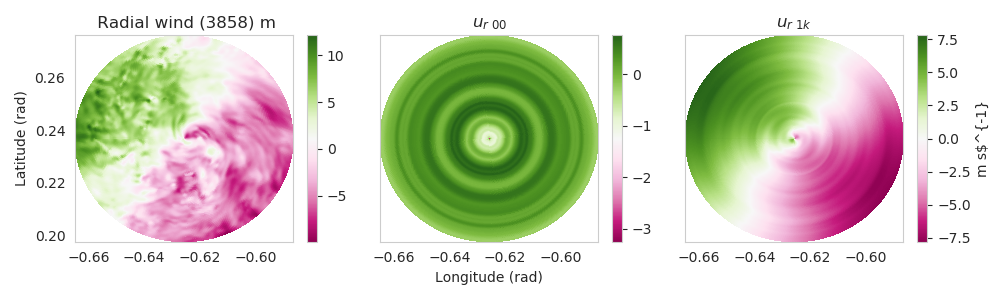

In [20]:
int_height= np.int(lev_height)

cp_map ="PiYG"

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(131)
cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar_i), cmap= cp_map)
ax.title.set_text(r' Radial wind (%s) m' % int_height)
cbar = plt.colorbar(cs, ax=ax)
plt.ylabel('Latitude (rad)')
plt.xlabel('')

ax = fig.add_subplot(132)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar1_i.x, fvar1_i.y, xr.ufuncs.real(fvar0_i), cmap= cp_map)
ax.title.set_text(r'$u_{r~00}$')
cbar = plt.colorbar(cs, ax=ax)
plt.xlabel('Longitude (rad)')

ax = fig.add_subplot(133)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar2_i.x, fvar2_i.y, 2*xr.ufuncs.real(fvar1_i), cmap= cp_map)
ax.title.set_text(r'$u_{r~1k}$')
cbar = plt.colorbar(cs, ax=ax)
cbar.ax.set_ylabel('m s$^{-1}')
plt.xlabel('')

plt.tight_layout()

In [16]:
# Calculate maximum value for every mode
fmodes_max = np.empty(len(fvar.k))
fmodes_mean = np.empty(len(fvar.k))
fmodes_min = np.empty(len(fvar.k))

for k in fvar.k.values:
    k = int(k)
    
    fvar_sub = fvar.copy()
    if k == 0:
        fvar_sub[1:] = 0.
    elif k == -1:
        fvar_sub[0:-1]= 0.
    else:
        fvar_sub[0:k] = 0.
        fvar_sub[k+1:] = 0.
    fvar_sub_i = xr.ufuncs.real(polar_idft(fvar_sub))
  
    fmodes_max[k] = fvar_sub_i.max()
    fmodes_min[k] = fvar_sub_i.min()
    fmodes_mean[k] = fvar_sub_i.mean()

<IPython.core.display.Javascript object>


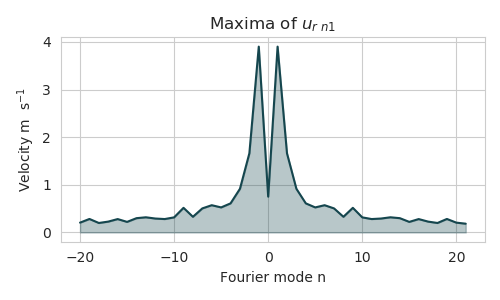

In [24]:
# Plot distribution of max values
sns.set_style("whitegrid")

k_vals = np.concatenate((fvar.k.values[-20:], fvar.k.values[0:22], ))
max_vals = np.concatenate(( fmodes_max[-20:], fmodes_max[0:22]))

blueish = sns.color_palette("cubehelix", 8)[1]
#violetish = sns.color_palette("cubehelix", 8)[5]


fig, ax = plt.subplots(figsize=(5,3))
ax.fill_between(k_vals, 0, max_vals, color=blueish, alpha=.3)
ax.plot(k_vals, max_vals, color=blueish, label="Maxima")

plt.title('Maxima of $u_{r~n1}$')
plt.xlabel('Fourier mode n')
plt.ylabel('Velocity m  s$^{-1}$')

plt.tight_layout()

<xarray.DataArray 'w' ()>
array(-0.00278656, dtype=float32)
Coordinates:
    height_2  float64 51.0
    time      datetime64[ns] 2016-08-17T12:00:00

In [11]:
# Calculate maximum value for every mode
# Imaginary part
fmodes_max_i = np.empty(len(fvar.k))
fmodes_mean_i = np.empty(len(fvar.k))
fmodes_min_i = np.empty(len(fvar.k))
var_i_max = xr.ufuncs.imag(fvar_i).max()

print(var_i_max)
for k in fvar.k.values:
    k = int(k)
    
    fvar_sub = fvar.copy()
    if k == 0:
        fvar_sub[1:] = 0.
    elif k == -1:
        fvar_sub[0:-1]= 0.
    else:
        fvar_sub[0:k] = 0.
        fvar_sub[k+1:] = 0.
    fvar_sub_i = polar_idft(fvar_sub)
  

    fmodes_max_i[k] = xr.ufuncs.imag(fvar_sub_i).max()
    #fmodes_min_i[k] = fvar_sub_i.min()
    #fmodes_mean_i[k] = fvar_sub_i.mean()


<xarray.DataArray ()>
array(5.38315792e-16)


In [59]:
fvar2 = fvar.copy()
fvar2[0:2] = 0.
fvar2[3:] = 0.
fvar2_i =polar_idft(fvar2, polar_dim='phi')

fvar_something = fvar.copy()
fvar_something [0:2] = 0.
fvar_something [2+1:] = 0.
fvar_something_i = polar_idft(fvar_something, polar_dim='phi' )

In [52]:

fvar_i.mean()

<xarray.DataArray ()>
array(-0.00407427+7.79000144e-36j)

In [49]:
ds_imag = xr.ufuncs.imag(fvar_something_i)
imag_max = ds_imag.max()
ds_imag.where(ds_imag == imag_max, drop = True)

<xarray.DataArray (phi: 2, r: 1)>
array([[0.08205667],
       [0.08205667]])
Coordinates:
  * r        (r) float64 0.004399
  * phi      (phi) float64 0.2136 3.355
    x        (phi, r) float64 -0.6299 -0.6213
    y        (phi, r) float64 0.2359 0.2378

In [ ]:
print(fmodes_max_i[2])
print(fmodes_max[2])
xr.ufuncs.imag(polar_idft(fvar_sub))
xr.ufuncs.imag(polar_idft(fvar_i))

<IPython.core.display.Javascript object>


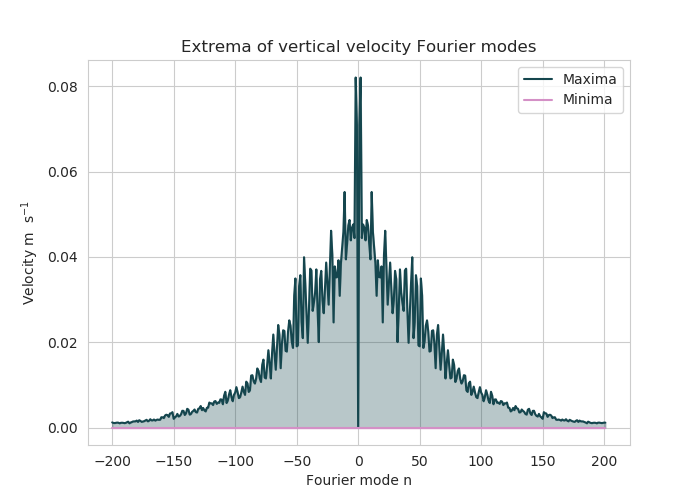

Text(0, 0.5, 'Velocity m  s$^{-1}$')

In [12]:
# Plot distribution of max values
sns.set_style("whitegrid")

k_vals = np.concatenate((fvar.k.values[-200:], fvar.k.values[0:202], ))
max_vals = np.concatenate(( fmodes_max_i[-200:], fmodes_max_i[0:202]))
min_vals = np.concatenate(( fmodes_min_i[-200:], fmodes_min_i[0:202]))

blueish = sns.color_palette("cubehelix", 8)[1]
violetish = sns.color_palette("cubehelix", 8)[5]


fig, ax = plt.subplots(figsize=(7,5))
ax.fill_between(k_vals, 0, max_vals, color=blueish, alpha=.3)
ax.plot(k_vals, max_vals, color=blueish, label="Maxima")
ax.fill_between(k_vals, 0, min_vals, color=violetish, alpha=.3)
ax.plot(k_vals, min_vals, color=violetish, label="Minima")

plt.legend()

plt.title('Extrema of vertical velocity Fourier modes')
plt.xlabel('Fourier mode n')
plt.ylabel('Velocity m  s$^{-1}$')